# Entries

1. Historical statistics of direct confrontation (team 1 vs team 2)
2. Statistics of *N* previous matches for each team
3. Home player or away player
4. Current points on championship
5. Match day matters?

In [1]:
import sys
sys.path.append("..")

In [2]:
from pprint import pprint
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from db.database import DAO

In [3]:
dao = DAO()
matches_collection = dao.matches()

In [4]:
# Sample match for testing
sample = matches_collection.find_one()
pprint(sample)

{'_id': ObjectId('5ac952926b5b9e2af46c59ef'),
 'arbiter': 'Leonardo Gaciba da Silva',
 'away_team': 'Santos',
 'cards': [{'player': 'Alex Sandro', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Zé Eduardo', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Herrera', 'team': 'BOT', 'type': 'yellow'},
           {'player': 'Wesley', 'team': 'SAN', 'type': 'yellow'},
           {'player': 'Alex Sandro', 'team': 'SAN', 'type': 'red'}],
 'coaches': {'away_team': 'Dorival Júnior', 'home_team': 'Joel Santana'},
 'home_team': 'Botafogo',
 'location': {'city': 'Brasil, Rio de Janeiro, RJ', 'stadium': 'Engenhão'},
 'players': {'away_team': [{'name': 'Felipe Garcia', 'position': 'GOL'},
                           {'name': 'Bruno Aguiar', 'position': 'ZAD'},
                           {'name': 'Durval', 'position': 'ZAE'},
                           {'name': 'Maranhão', 'position': 'LAD'},
                           {'name': 'Alex Sandro', 'position': 'LAE'},
                     

## Match Vectorizer
Takes a match in the above format and extracts the most important characteristics in the following order:

<ol>
- Current match statistics
<li> Home team score </li>
<li> Away team score </li>

- Statistics of all confronts of the teams
<li> Goals by home team </li>
<li> Goals by away team </li>
<li> Number of victories of home team </li>
<li> Number o victories of away team </li>
<li> Number of draws </li>

- Statistics of N previous games of each team
<li> Balance of N last games of home team </li>
<li> Balance of N last games of away team </li>
</ol>

In [85]:
# Default match feature extractor. ht is home_team and at is away_team
N = 4
labels = ['ht_score', 'at_score', 'goals_ht', 'goals_at', 'wins_ht', 'wins_at', 'draws', 
          *(['sg_ht']*N), *(['sg_at']*N)]
def vectorize_match(dao, match, N):
    stats = match['statistics']
    score = match['score']
    home_team_last_sg = dao.get_last_N_balances(match['home_team'], N)
    away_team_last_sg = dao.get_last_N_balances(match['away_team'], N)
    return [
            score['home_team'],
            score['away_team'], 
            stats['goals_home_team'], 
            stats['goals_away_team'],
            stats['wins_home_team'], 
            stats['wins_away_team'], 
            stats['previous_draws'], 
            *home_team_last_sg, 
            *away_team_last_sg
           ]

In [86]:
# Vectorize matches from 2016
matches = matches_collection.find({'year':2016})
data = [vectorize_match(dao, match, N) for match in matches]
data = pd.DataFrame(data=data, columns=labels)
data.head()

,ht_score,at_score,goals_ht,goals_at,wins_ht,wins_at,draws,sg_ht,sg_ht,sg_ht,sg_ht,sg_at,sg_at,sg_at,sg_at
0,4,0,50,39,15,8,13,-1,1,1,0,-2,-1,2,0
1,1,0,48,35,16,9,8,-1,0,2,-2,-1,0,-2,-1
2,1,0,92,80,25,19,17,2,-2,0,0,1,1,-2,2
3,1,0,48,62,10,17,12,0,-1,-1,0,0,1,1,1
4,0,1,72,97,21,26,13,-1,1,2,2,1,0,1,0


In [87]:
# Splitting X and Y
Y = data.iloc[:,:2]
X = data.iloc[:,2:]
Y.head() # Y.values to extract the matrix from dataframe

,ht_score,at_score
0,4,0
1,1,0
2,1,0
3,1,0
4,0,1


In [88]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
xscaler = StandardScaler()
yscaler = StandardScaler()
X = xscaler.fit_transform(X)
#Y = yscaler.fit_transform(Y)

In [89]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## Building the Perceptron ANN

In [90]:
from keras.models import Sequential
from keras.layers import Dense

In [91]:
# Creating the neural network
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(8, input_dim=len(X_train[0]), activation='linear'))
model.add(Dense(2, activation='selu'))

model.compile(loss='mse', optimizer='sgd', metrics=['binary_accuracy'])

1. linear + sigmoid :69.74%
2. linear + linear : 73.68
3. softsign 69.74
4. tanh 72.37 = elu

In [92]:
# Training
model.fit(X_train, Y_train, epochs=150, batch_size=10, validation_split=0.1)
scores = model.evaluate(X_test, Y_test)

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Train on 272 samples, validate on 31 samples
Epoch 1/150
272/272 [==============================] - 0s 1ms/step - loss: 3.6417 - binary_accuracy: 0.2151 - val_loss: 2.0277 - val_binary_accuracy: 0.2419
Epoch 2/150
272/272 [==============================] - 0s 285us/step - loss: 1.7855 - binary_accuracy: 0.3382 - val_loss: 1.4157 - val_binary_accuracy: 0.3065
Epoch 3/150
272/272 [==============================] - 0s 278us/step - loss: 1.3742 - binary_accuracy: 0.3640 - val_loss: 1.3420 - val_binary_accuracy: 0.2581
Epoch 4/150
272/272 [==============================] - 0s 273us/step - loss: 1.2577 - binary_accuracy: 0.3621 - val_loss: 1.2259 - val_binary_accuracy: 0.2903
Epoch 5/150
272/272 [==============================] - 0s 236us/step - loss: 1.2015 - binary_accuracy: 0.3401 - val_loss: 1.2143 - val_binary_accuracy: 0.2581
Epoch 6/150
272/272 [==============================] - 0s 261us/step - loss: 1.1921 - binary_accuracy: 0.3456 - val_loss: 1.2932 - val_binary_accuracy: 0.2581
Epo

Epoch 52/150
272/272 [==============================] - 0s 234us/step - loss: 1.1362 - binary_accuracy: 0.3474 - val_loss: 1.1198 - val_binary_accuracy: 0.2258
Epoch 53/150
272/272 [==============================] - 0s 297us/step - loss: 1.1317 - binary_accuracy: 0.3419 - val_loss: 1.1318 - val_binary_accuracy: 0.2581
Epoch 54/150
272/272 [==============================] - 0s 234us/step - loss: 1.1269 - binary_accuracy: 0.3640 - val_loss: 1.1437 - val_binary_accuracy: 0.2419
Epoch 55/150
272/272 [==============================] - 0s 246us/step - loss: 1.1281 - binary_accuracy: 0.3382 - val_loss: 1.1455 - val_binary_accuracy: 0.2581
Epoch 56/150
272/272 [==============================] - 0s 204us/step - loss: 1.1251 - binary_accuracy: 0.3511 - val_loss: 1.2998 - val_binary_accuracy: 0.2419
Epoch 57/150
272/272 [==============================] - 0s 276us/step - loss: 1.1422 - binary_accuracy: 0.3732 - val_loss: 1.1866 - val_binary_accuracy: 0.2581
Epoch 58/150
272/272 [==================

272/272 [==============================] - 0s 242us/step - loss: 1.1231 - binary_accuracy: 0.3548 - val_loss: 1.1483 - val_binary_accuracy: 0.3065
Epoch 104/150
272/272 [==============================] - 0s 241us/step - loss: 1.1183 - binary_accuracy: 0.3529 - val_loss: 1.1434 - val_binary_accuracy: 0.2581
Epoch 105/150
272/272 [==============================] - 0s 281us/step - loss: 1.1130 - binary_accuracy: 0.3493 - val_loss: 1.1500 - val_binary_accuracy: 0.2903
Epoch 106/150
272/272 [==============================] - 0s 205us/step - loss: 1.1188 - binary_accuracy: 0.3529 - val_loss: 1.1222 - val_binary_accuracy: 0.2258
Epoch 107/150
272/272 [==============================] - 0s 231us/step - loss: 1.1145 - binary_accuracy: 0.3456 - val_loss: 1.1481 - val_binary_accuracy: 0.2419
Epoch 108/150
272/272 [==============================] - 0s 267us/step - loss: 1.1192 - binary_accuracy: 0.3438 - val_loss: 1.1744 - val_binary_accuracy: 0.2258
Epoch 109/150
272/272 [=========================

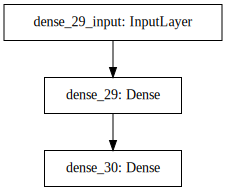

In [84]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [94]:
predictions = model.evaluate(X_test, Y_test)
predictions

76/76 [==============================] - 0s 110us/step


[0.6956214716559962, 0.4473684226211749]

In [ ]:
# calculate predictions
predictions = model.predict(X_test)
result = np.matrix.round(predictions)
pprint(result == Y_test)